# COVID-19 Vaccination Twitter Clustering

> 👩🏻‍💻 Shengchen Zhang <br>
> ✉️ shengchenzhang1207@gmail.com <br>
> 🏠 College of Design and Innovarion, Tongji University <br>
> 📍 Shanghai, China

Create semantically-meaningful clusters from Twitter discourse on COVID-19 vaccination. The method we use is informed by [BERTopic](https://github.com/MaartenGr/BERTopic) and [this blog post](https://www.atoti.io/topic-modeling-on-twitter-using-sentence-bert/), modified to fit our purpose.

The steps we take are as follows:
1. Create dense vector embeddings from the original tweet texts.
2. Perform dimensionality reduction on the vectors
3. Cluster the reduced vectors.
4. Filter outliers and merge clusters to arrive at desired number of clusters.

## Step 1: Embed the tweets

Create embedding vectors for the tweets using [SentenceTransformer](https://www.sbert.net/index.html), a transformer-based library that creates dence vector embedding for sentences.

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

### 1. Create SentenceTransformer model

According to the SentenceTransformer team, `paraphrase-mpnet-base-v2` is the best performing model. But it might be slower to run.

In [2]:
model = SentenceTransformer('paraphrase-mpnet-base-v2')

### 2. Prepare the dataset

Here we load the dataset, then create a list of sentences from that.

In [3]:
dataset = pd.read_csv('./data/vaccination_all_tweets.csv')

In [25]:
sentences = [row['text'] for i, row in dataset.iterrows()]
sentences[:5]

['@SAHPRA1 @SAPoliceService Why is @SAHPRA1 ONLY approving WESTERN MANUFACTURED VACCINES created late into Covid and… https://t.co/1fZcP9As0t',
 '@javedstringer My cousin was died last week due shot of #sinopharm',
 'UPDATE | African Union may endorse #SputnikV vaccine in coming days, health official says\n\n#SputnikUpdates https://t.co/PkBRsL3c5v',
 'When will the #Sinovac (inactivated) #CovidVaccine become available in the UK? or in Europe?\nhttps://t.co/GHB3ZXkWyv',
 '@JustinTrudeau  Biden just announced moved up delivery dates for #Pfizer and #moderna for 200 million doses by July… https://t.co/3pyweWi3ew']

### 2.5. Testing only: subsample the sentences to speed up the computation

In [5]:
import random

sentences = random.sample(sentences, 1000)

### 3. Calculate sentence embeddings (takes a long time!)

In [26]:
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

## Step 2: Dimensionality reduction

We then reduce the dimensionality of the embeddings from 200-D to 5-D. This helps the clustering algorithm.

Here we use UMAP as recommended by [this post](https://www.atoti.io/topic-modeling-on-twitter-using-sentence-bert/), since it is better at preserving local structures, and tweets are all about subtle local structures.

In [27]:
from umap import UMAP

### 1. Compare UMAP and t-SNE

First, we do a bit of visualization to compare the effectiveness of UMAP and t-SNE. Theoretically, we should observe that UMAP produces **richer structures (clusters, outliers, etc.)**, while t-SNE yields a more **uniform (mixed and spread-out)** result.

In [28]:
import plotly.express as px

reducer = UMAP()

coords = reducer.fit_transform(embeddings).transpose()  # Create a 2-D version for visualization
dataframe = pd.DataFrame({'text': sentences, 'x': coords[0], 'y': coords[1]})

fig = px.scatter(dataframe, x='x', y='y', hover_name='text')
fig.show()

In [29]:
import plotly.express as px
from sklearn.manifold import TSNE

reducer = TSNE(n_components=2)

coords = reducer.fit_transform(embeddings).transpose()  # Create a 2-D version for visualization
dataframe = pd.DataFrame({'text': sentences, 'x': coords[0], 'y': coords[1]})

fig = px.scatter(dataframe, x='x', y='y', hover_name='text')
fig.show()

### 2. The real deal

Now is time to really do the reduction. We create a UMAP reducer with `n_components=5` to get 5-D vectors.

In [30]:
reducer = UMAP(n_components=5)
reduced = reducer.fit_transform(embeddings)
reduced.shape  # Should be (*, 5)

(888, 5)

## Step 3: Clustering

Using the reduced vectors, we can now cluster our tweets.

Also following [this post](https://www.atoti.io/topic-modeling-on-twitter-using-sentence-bert/), we use HDBSCAN to cluster out tweets. According to the author, this algorithm is better at filtering out outliers.

In [41]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=5)
labels = clusterer.fit_predict(reduced)

<AxesSubplot:ylabel='$\\lambda$ value'>

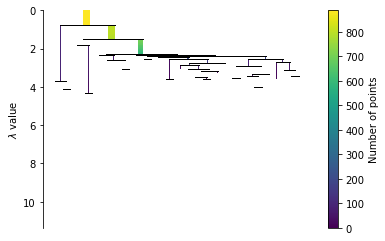

In [42]:
clusterer.condensed_tree_.plot()

## Step 4: Visualization of results

In [43]:
import plotly.express as px

reducer = UMAP()

coords = reducer.fit_transform(embeddings).transpose()  # Create a 2-D version for visualization
dataframe = pd.DataFrame({'text': sentences, 'x': coords[0], 'y': coords[1], 'cluster': labels})

fig = px.scatter(dataframe, x='x', y='y', hover_name='text', color='cluster')
fig.show()

In [24]:
dataset = dataframe[dataframe['cluster'] != -1]